In [2]:
#!pip install mahotas
#!pip install git+https://github.com/openai/CLIP.git
#!pip install torch torchvision

In [1]:
import os
import glob
import pandas as pd
import numpy as np
from PIL import Image
from skimage.measure import shannon_entropy
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

from torchvision import models, transforms
import torch
from torchvision.models import resnet18, ResNet18_Weights
try:
    import mahotas
    haralick_available = True
except ImportError:
    print("⚠️ Mahotas not installed – Haralick features won't be used.")
    haralick_available = False

# Przygotuj model ResNet18 bez klasyfikatora
# Załaduj model i wagę
weights = ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights)
resnet.eval()
resnet_embed = torch.nn.Sequential(*list(resnet.children())[:-1])  # bez klasyfikatora

# Dopasowany transform (rozmiar + normalizacja z ImageNet)
resnet_transform = weights.transforms()

def extract_features_from_folders(folder_paths):
    all_features = []

    for folder_path in folder_paths:
        folder_path = os.path.normpath(folder_path)
        image_paths = glob.glob(os.path.join(folder_path, '**', '*.jpg'), recursive=True)
        image_paths += glob.glob(os.path.join(folder_path, '**', '*.png'), recursive=True)

        if len(image_paths) == 0:
            print(f"⚠️ Brak obrazków w folderze: {folder_path}")
            continue

        for image_path in image_paths:
            try:
                img = Image.open(image_path).convert('RGB')  # ResNet wymaga RGB
                img_gray = img.convert('L')
                img_array = np.array(img_gray).astype(np.uint8)

                # Statystyki z obrazu szarego
                features = {
                    'path': image_path,
                    'mean_intensity': np.mean(img_array),
                    'std_intensity': np.std(img_array),
                    'min_intensity': np.min(img_array),
                    'max_intensity': np.max(img_array),
                    'skewness': skew(img_array.flatten()),
                    'kurtosis': kurtosis(img_array.flatten()),
                    'entropy': shannon_entropy(img_array)
                }

                # Haralick
                if haralick_available:
                    h = mahotas.features.haralick(img_array).mean(axis=0)
                    for i, val in enumerate(h):
                        features[f'haralick_{i+1}'] = val

                # Embedding ResNet
                input_tensor = resnet_transform(img).unsqueeze(0)  # dodaj batch dimension
                with torch.no_grad():
                    embedding = resnet_embed(input_tensor).squeeze().numpy()  # [512]
                for i, val in enumerate(embedding):
                    features[f'resnet_emb_{i+1}'] = val

                all_features.append(features)

            except Exception as e:
                print(f"❌ Błąd przy {image_path}: {e}")

    if len(all_features) == 0:
        print("🚫 Nie znaleziono żadnych poprawnych obrazków. Nie tworzę pliku.")
        return None

    df = pd.DataFrame(all_features)

    # Zapis
    os.makedirs("data_tables", exist_ok=True)
    base_name = '_'.join([os.path.basename(path.rstrip('/\\')) for path in folder_paths])
    output_csv = f"data_tables/features_from_{base_name}.csv"
    df.to_csv(output_csv, index=False)

    # Statystyki
    print(f"\n📊 Statystyki cech ({output_csv}):\n")
    print(df.describe())

    # Wizualizacja cech (nie embeddingów, tylko bazowe)
    plot_cols = ['mean_intensity', 'std_intensity', 'entropy', 'skewness', 'kurtosis', 'min_intensity']
    existing_cols = [col for col in plot_cols if col in df.columns]
    df[existing_cols].hist(bins=20, figsize=(14, 6))
    plt.suptitle(f'Cechy z folderów: {base_name}')
    plt.tight_layout()
    plt.show()

    # Wizualizacja wybranych wymiarów embeddingów
    embed_cols = [col for col in df.columns if col.startswith('resnet_emb_')]
    if embed_cols:
        df[embed_cols[:5]].hist(bins=20, figsize=(14, 6))
        plt.suptitle(f'Embeddingi ResNet (pierwsze 5) – {base_name}')
        plt.tight_layout()
        plt.show()

    return df


c:\Users\66891\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\66891\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Przetwarzam folder: DATA\Backup

📊 Statystyki cech (data_tables/features_from_Backup.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count      961.000000     961.000000     961.000000     961.000000   
mean        86.381546      45.013655      13.285120     233.064516   
std         42.017497      14.233452      19.361686      29.258332   
min          6.759825       9.674952       0.000000      69.000000   
25%         51.181382      34.245778       0.000000     221.000000   
50%         83.545769      44.417839       4.000000     246.000000   
75%        117.240613      54.477694      19.000000     254.000000   
max        226.289062      85.534833     113.000000     255.000000   

         skewness    kurtosis     entropy  haralick_1   haralick_2  \
count  961.000000  961.000000  961.000000  961.000000   961.000000   
mean     0.866168    1.208677    6.435501    0.032393   197.472418   
std      1.010768    2.741300    0.999555    0.080342   187.730982 

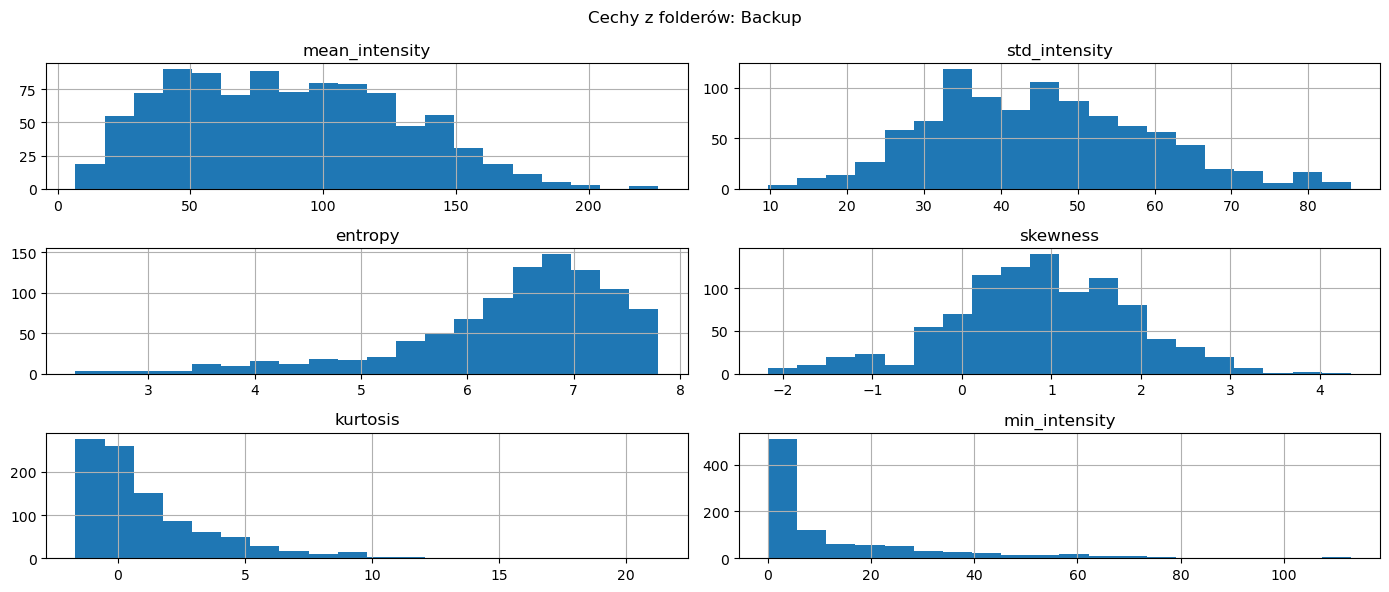

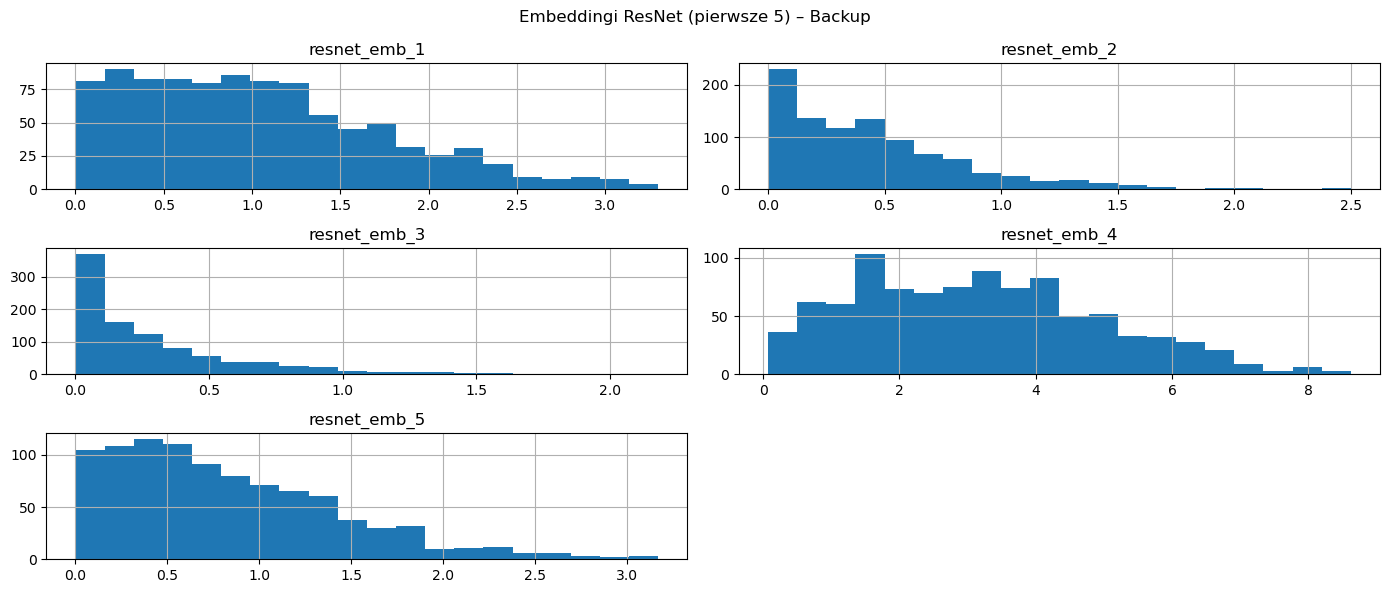

Przetwarzam folder: DATA\CLAHE_Color

📊 Statystyki cech (data_tables/features_from_CLAHE_Color.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count      956.000000     956.000000     956.000000     956.000000   
mean       130.411973      64.192998       1.900628     254.352510   
std          9.685156       8.090056       2.172546       1.080142   
min         35.841458      18.857217       0.000000     246.000000   
25%        126.076710      63.151241       0.000000     254.000000   
50%        129.161601      65.606561       1.000000     255.000000   
75%        131.654167      68.201158       3.000000     255.000000   
max        201.822864      88.122391      12.000000     255.000000   

         skewness    kurtosis     entropy  haralick_1   haralick_2  \
count  956.000000  956.000000  956.000000  956.000000   956.000000   
mean     0.089288   -0.754830    7.705886    0.004463   942.586010   
std      0.316420    1.639979    0.502097    0.022864   8

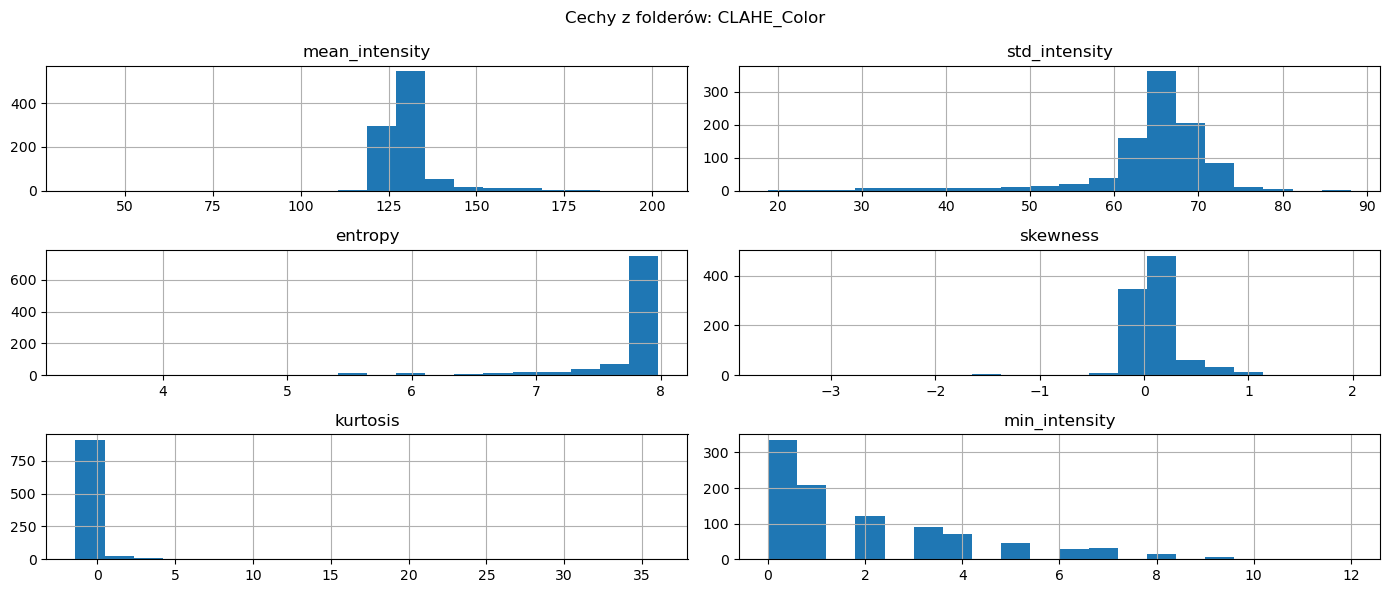

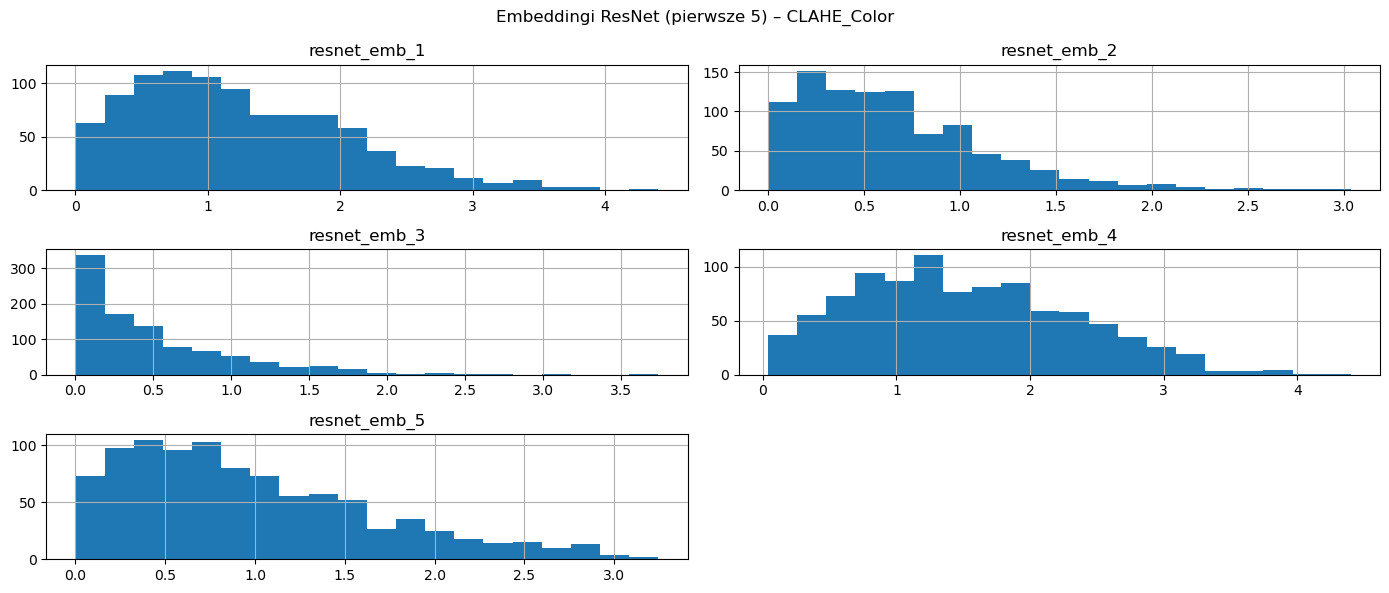

Przetwarzam folder: DATA\Equalized2_Color

📊 Statystyki cech (data_tables/features_from_Equalized2_Color.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count      956.000000     956.000000     956.000000     956.000000   
mean       133.100049      69.065397       1.976987     253.633891   
std         11.410926       9.103948       2.504759       1.861672   
min         34.136759      16.263648       0.000000     238.000000   
25%        128.626719      70.390798       0.000000     253.000000   
50%        129.466936      72.259781       1.000000     254.000000   
75%        131.835609      73.007897       3.000000     255.000000   
max        210.326730      99.119080      14.000000     255.000000   

         skewness    kurtosis     entropy  haralick_1   haralick_2  \
count  956.000000  956.000000  956.000000  956.000000   956.000000   
mean    -0.009480   -0.831989    7.265661    0.023808   590.642658   
std      0.343023    3.115867    1.048278    0.

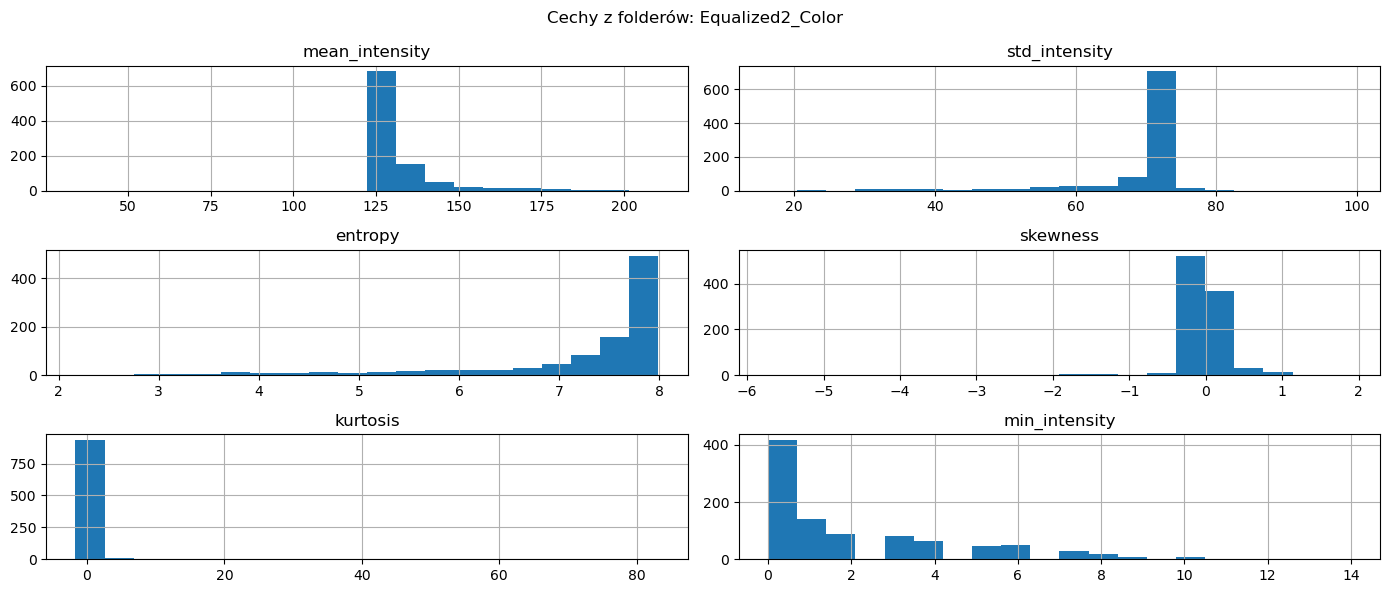

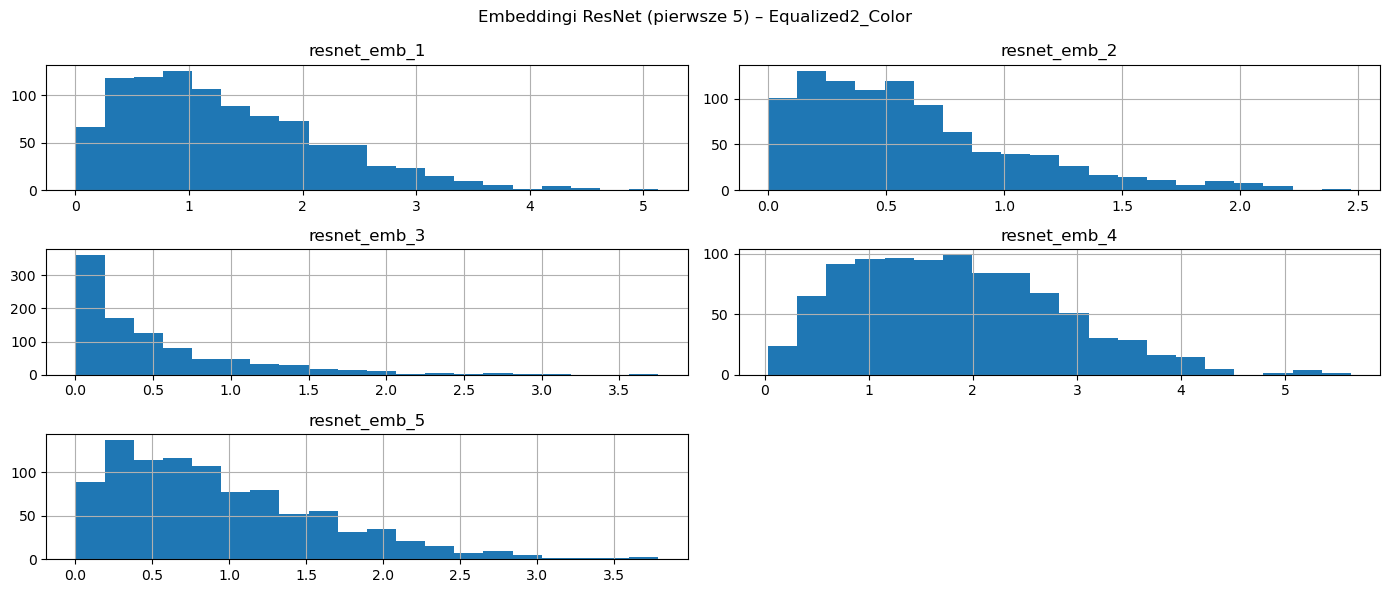

Przetwarzam folder: DATA\Equalized_Copy

📊 Statystyki cech (data_tables/features_from_Equalized_Copy.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count      956.000000     956.000000     956.000000          956.0   
mean       133.195583      69.627952       0.004184          255.0   
std         11.443430       9.156121       0.129369            0.0   
min         34.145667      16.533569       0.000000          255.0   
25%        128.703369      70.828044       0.000000          255.0   
50%        129.566516      73.067498       0.000000          255.0   
75%        131.914621      73.535835       0.000000          255.0   
max        210.433534      99.668855       4.000000          255.0   

         skewness    kurtosis     entropy  haralick_1   haralick_2  \
count  956.000000  956.000000  956.000000  956.000000   956.000000   
mean    -0.002179   -0.817882    7.310853    0.023773   599.903359   
std      0.334374    2.968898    1.057442    0.0693

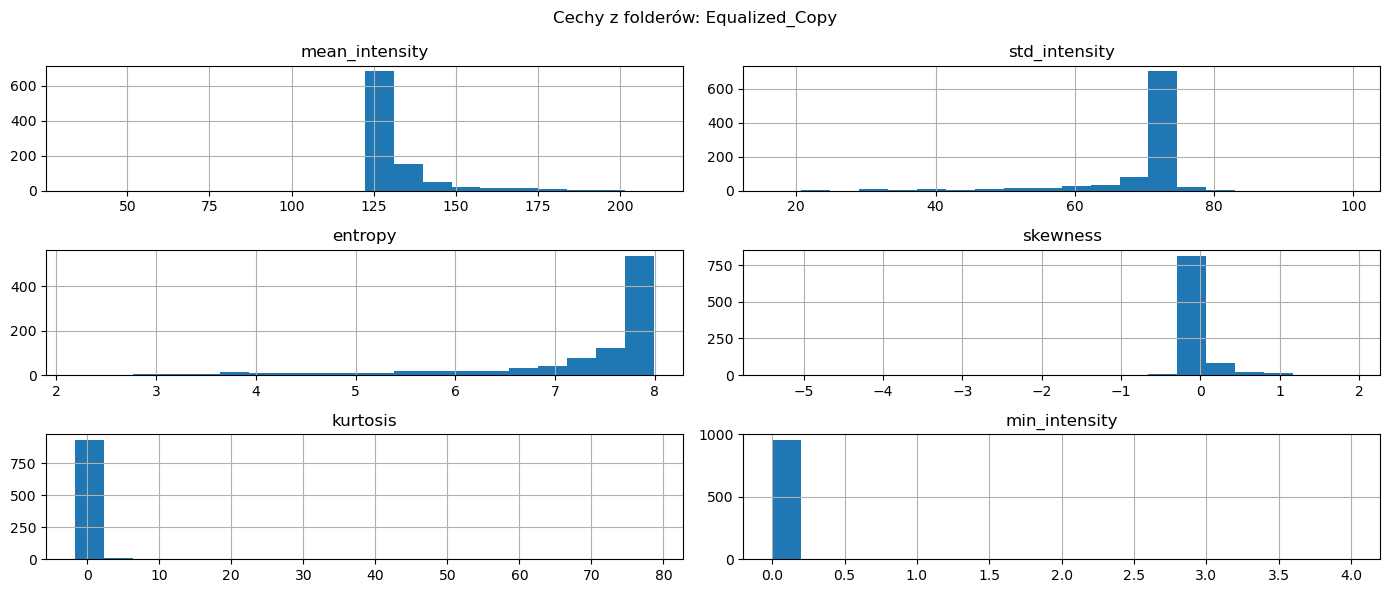

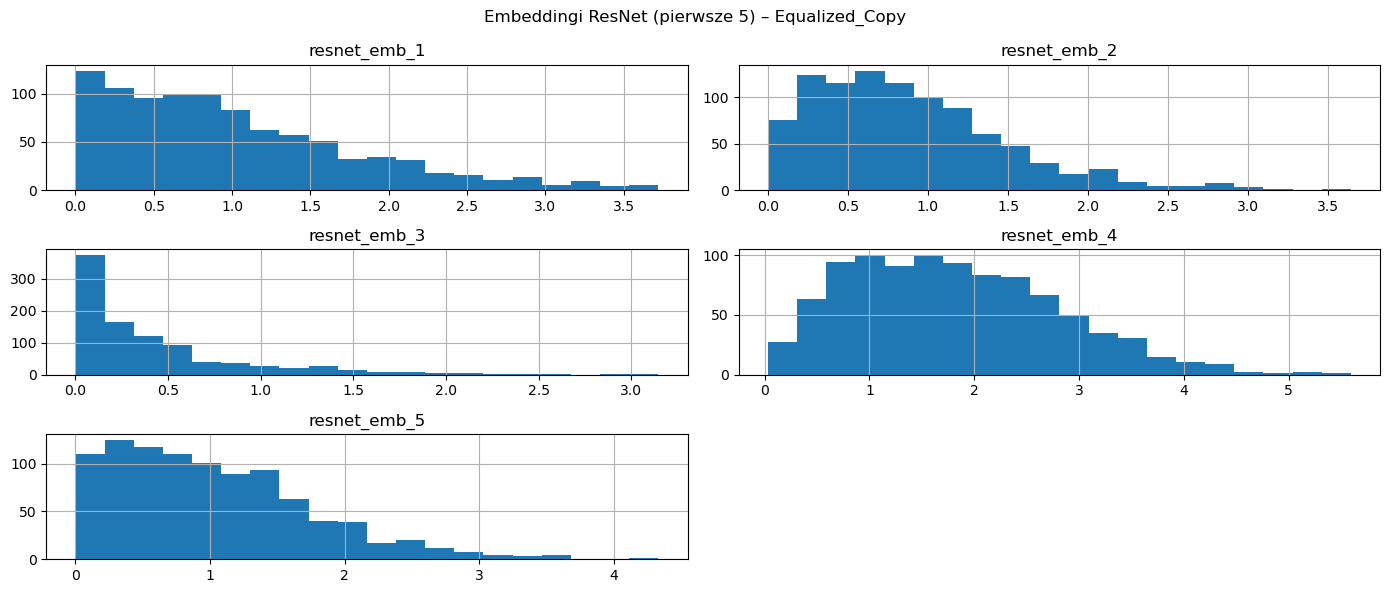

Przetwarzam folder: DATA\Rotated

📊 Statystyki cech (data_tables/features_from_Rotated.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count     4780.000000    4780.000000         4780.0    4780.000000   
mean       119.989996      70.492656            0.0     253.889331   
std          9.471192       5.399127            0.0       1.296934   
min         35.282246      40.686472            0.0     245.000000   
25%        114.893156      68.073818            0.0     253.000000   
50%        119.000100      71.198727            0.0     254.000000   
75%        123.536487      73.844818            0.0     255.000000   
max        193.879783      99.754904            0.0     255.000000   

          skewness     kurtosis      entropy   haralick_1   haralick_2  \
count  4780.000000  4780.000000  4780.000000  4780.000000  4780.000000   
mean     -0.055319    -0.841579     7.535154     0.006955   588.703574   
std       0.302412     0.771619     0.392058     0.01

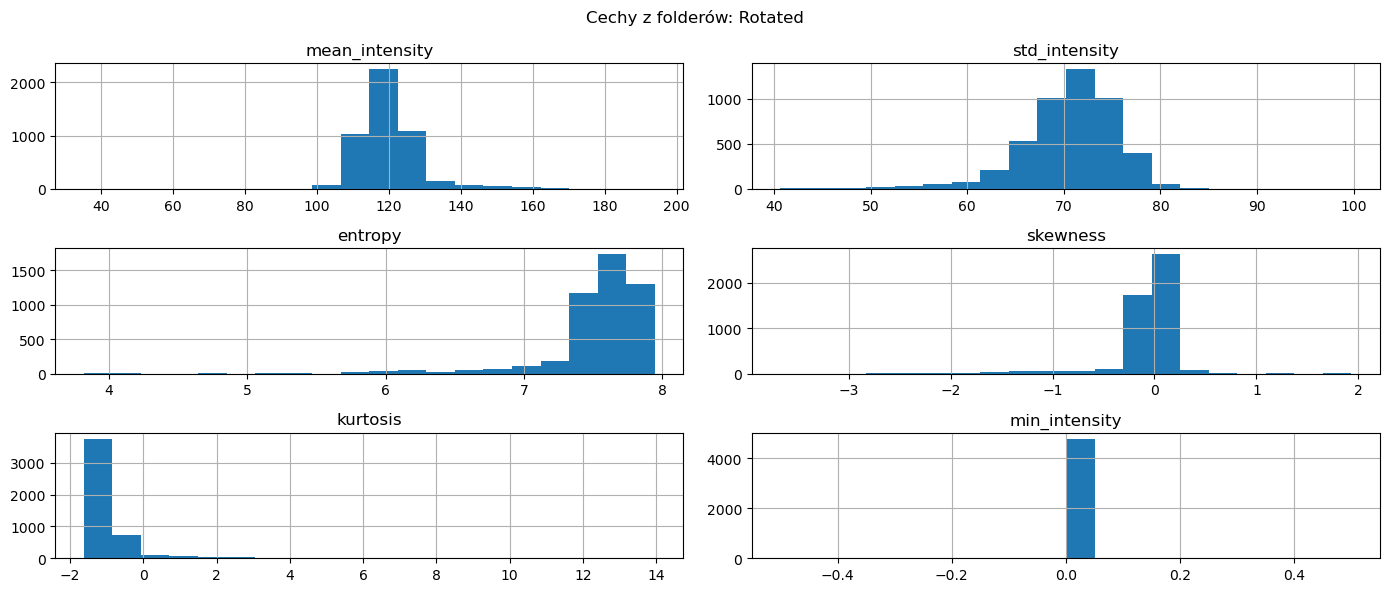

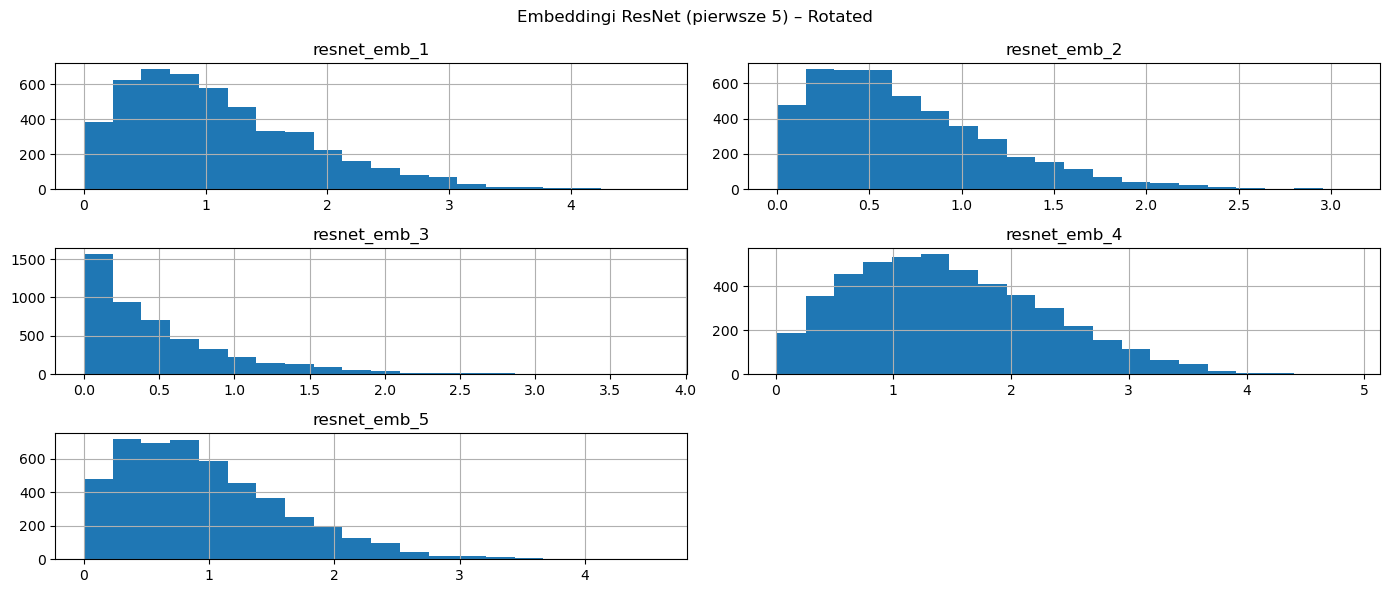

Przetwarzam folder: DATA\rotated-cutted

📊 Statystyki cech (data_tables/features_from_rotated-cutted.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count     5440.000000    5440.000000         5440.0    5440.000000   
mean        63.960879      86.225601            0.0     253.720404   
std         24.049176      12.577198            0.0       2.118989   
min          0.548509      10.405519            0.0     226.000000   
25%         47.979228      85.449653            0.0     253.000000   
50%         69.014439      90.924639            0.0     254.000000   
75%         82.413220      93.399884            0.0     255.000000   
max        152.984295     111.232963            0.0     255.000000   

          skewness     kurtosis      entropy   haralick_1   haralick_2  \
count  5440.000000  5440.000000  5440.000000  5440.000000  5440.000000   
mean      1.061741     0.598592     3.852675     0.322315   813.341983   
std       1.105159     9.153043     1.3

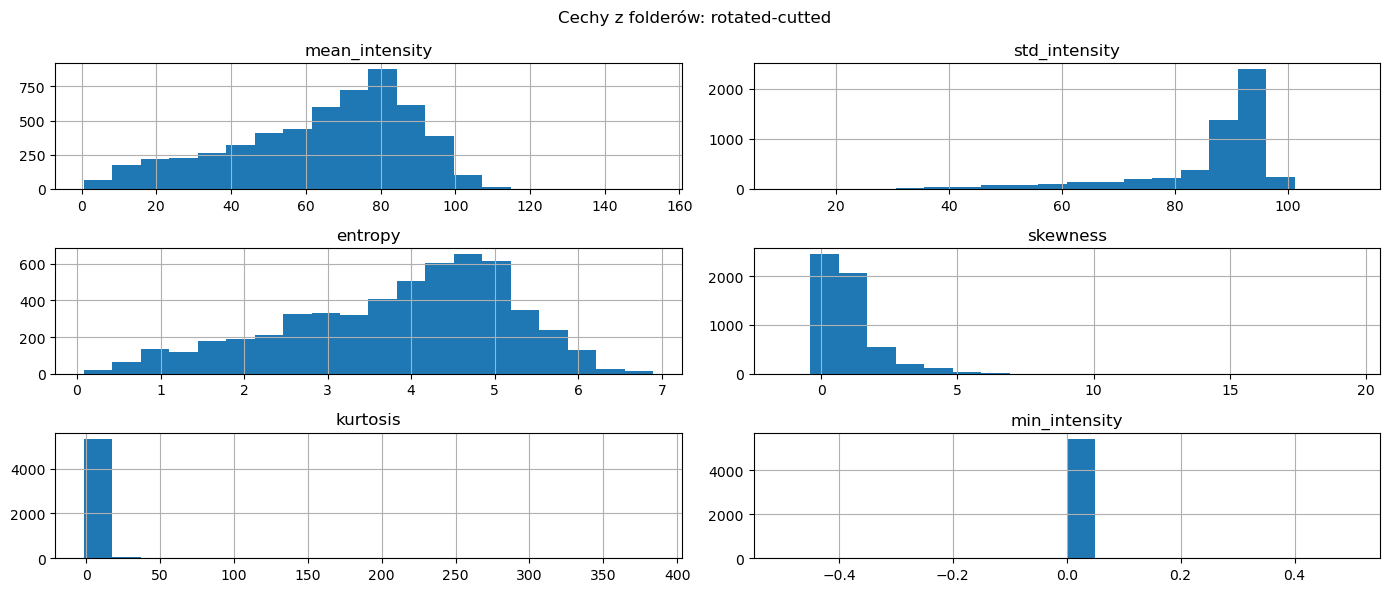

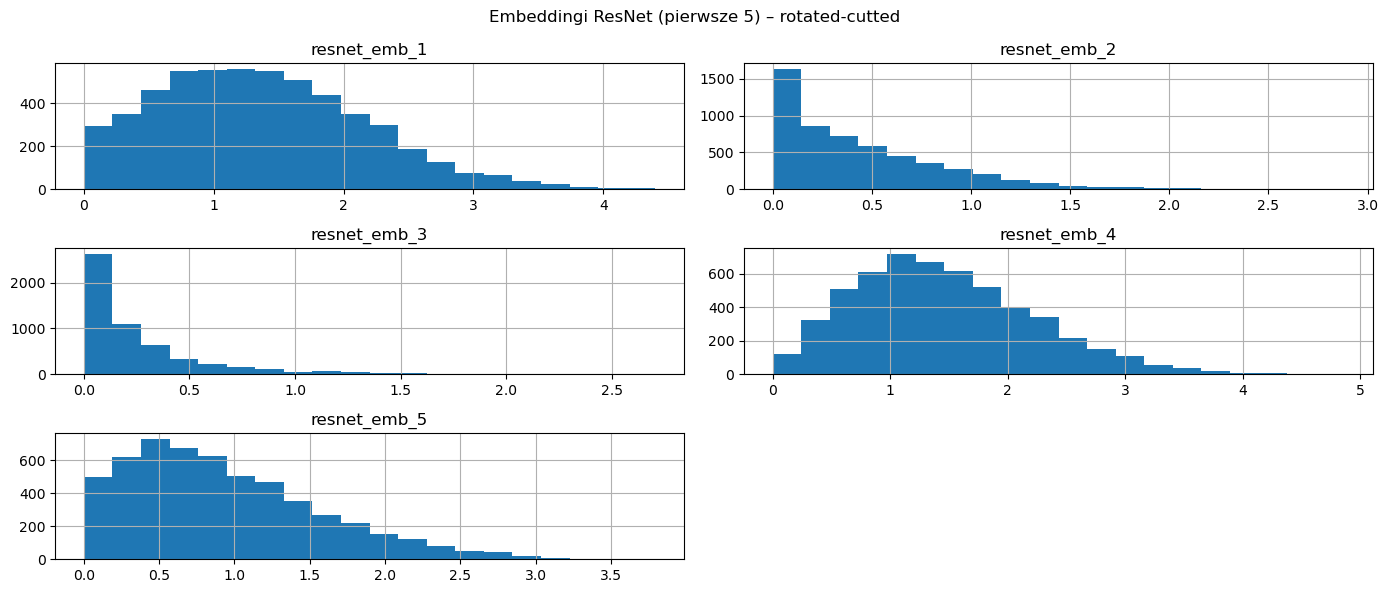

Przetwarzam folder: DATA\Rotated_Klasteryzacja

📊 Statystyki cech (data_tables/features_from_Rotated_Klasteryzacja.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count     5440.000000    5440.000000         5440.0    5440.000000   
mean       119.950789      70.479670            0.0     253.884559   
std          9.479885       5.393751            0.0       1.309834   
min         35.282246      40.686472            0.0     245.000000   
25%        114.827966      68.070228            0.0     253.000000   
50%        118.993423      71.175745            0.0     254.000000   
75%        123.538754      73.821579            0.0     255.000000   
max        193.879783      99.754904            0.0     255.000000   

          skewness     kurtosis      entropy   haralick_1   haralick_2  \
count  5440.000000  5440.000000  5440.000000  5440.000000  5440.000000   
mean     -0.054172    -0.842168     7.536311     0.006957   591.013355   
std       0.302556     0.

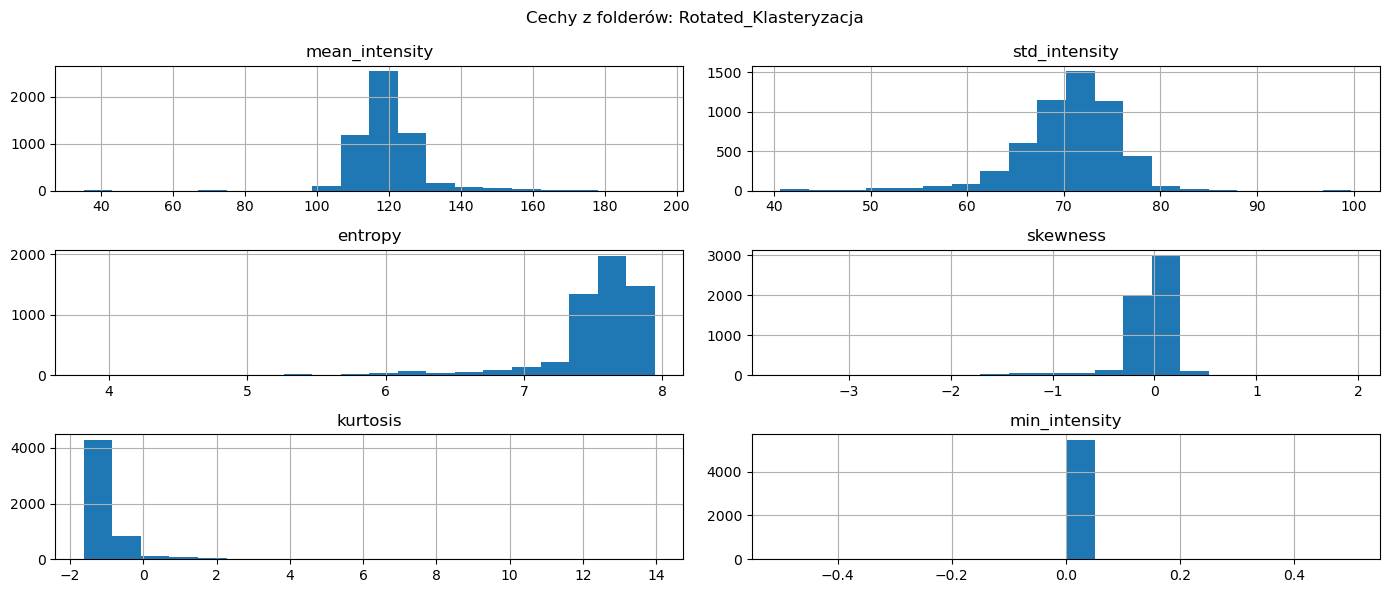

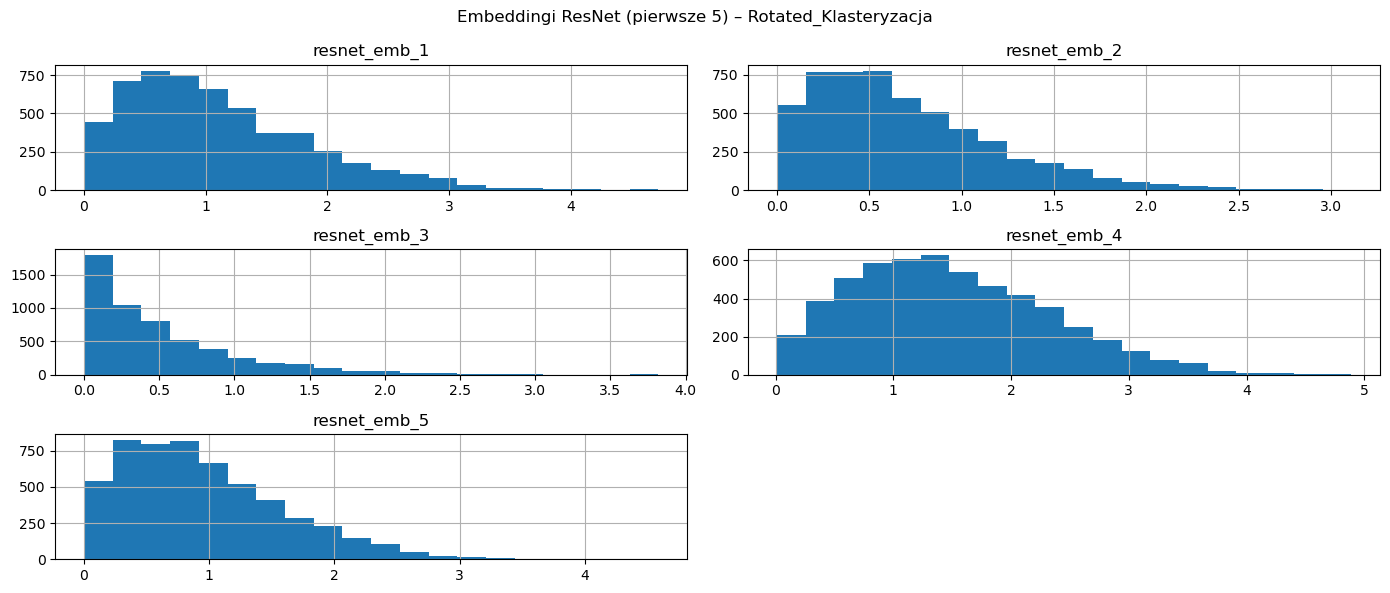

Przetwarzam folder: DATA\Standardized2_Resized

📊 Statystyki cech (data_tables/features_from_Standardized2_Resized.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count      956.000000     956.000000     956.000000     956.000000   
mean        88.214385      40.378077      19.834728     224.415272   
std         40.833015      13.808164      19.474722      27.953404   
min          3.455995       7.414216       0.000000      94.000000   
25%         54.895074      30.365348       6.000000     213.000000   
50%         89.740733      39.270209      14.000000     234.000000   
75%        117.900316      49.894663      28.000000     244.000000   
max        222.026846      82.668432     121.000000     255.000000   

         skewness    kurtosis     entropy  haralick_1   haralick_2  \
count  956.000000  956.000000  956.000000  956.000000   956.000000   
mean     0.871690    1.391978    6.308299    0.032384   142.976545   
std      1.024836    2.971651    1.00

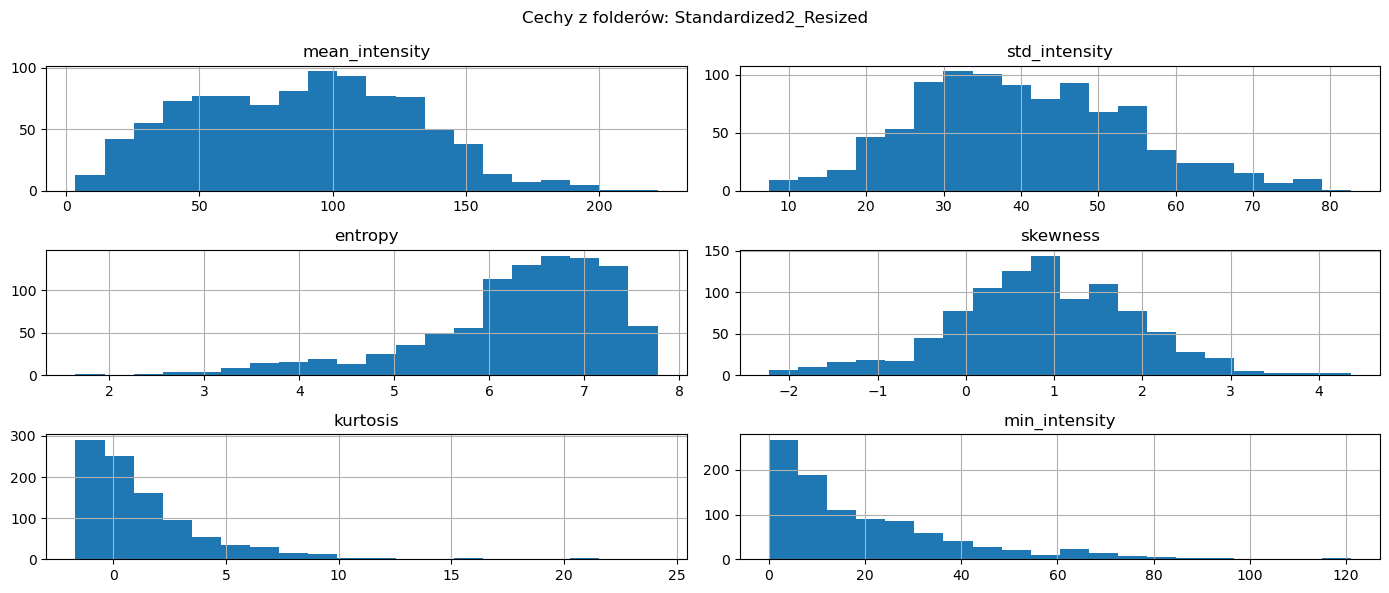

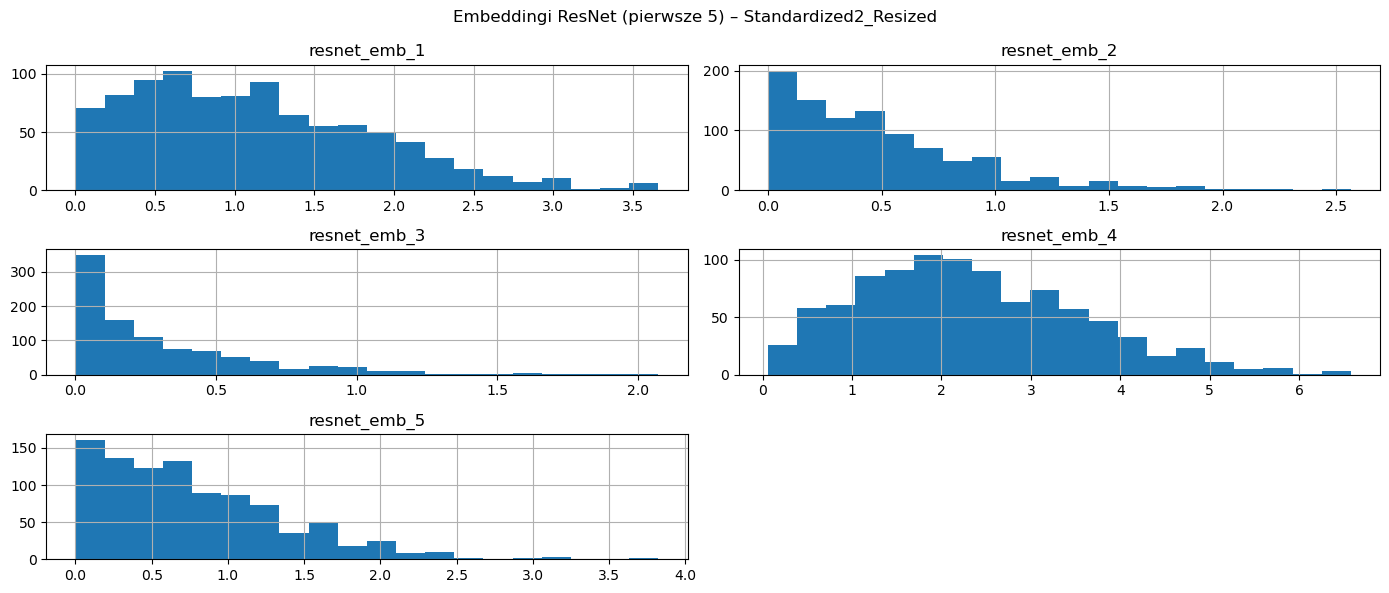

Przetwarzam folder: DATA\Standardized_Copy

📊 Statystyki cech (data_tables/features_from_Standardized_Copy.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count      956.000000     956.000000     956.000000     956.000000   
mean        88.214385      40.378077      19.834728     224.415272   
std         40.833015      13.808164      19.474722      27.953404   
min          3.455995       7.414216       0.000000      94.000000   
25%         54.895074      30.365348       6.000000     213.000000   
50%         89.740733      39.270209      14.000000     234.000000   
75%        117.900316      49.894663      28.000000     244.000000   
max        222.026846      82.668432     121.000000     255.000000   

         skewness    kurtosis     entropy  haralick_1   haralick_2  \
count  956.000000  956.000000  956.000000  956.000000   956.000000   
mean     0.871690    1.391978    6.308299    0.032384   142.976545   
std      1.024836    2.971651    1.006407    

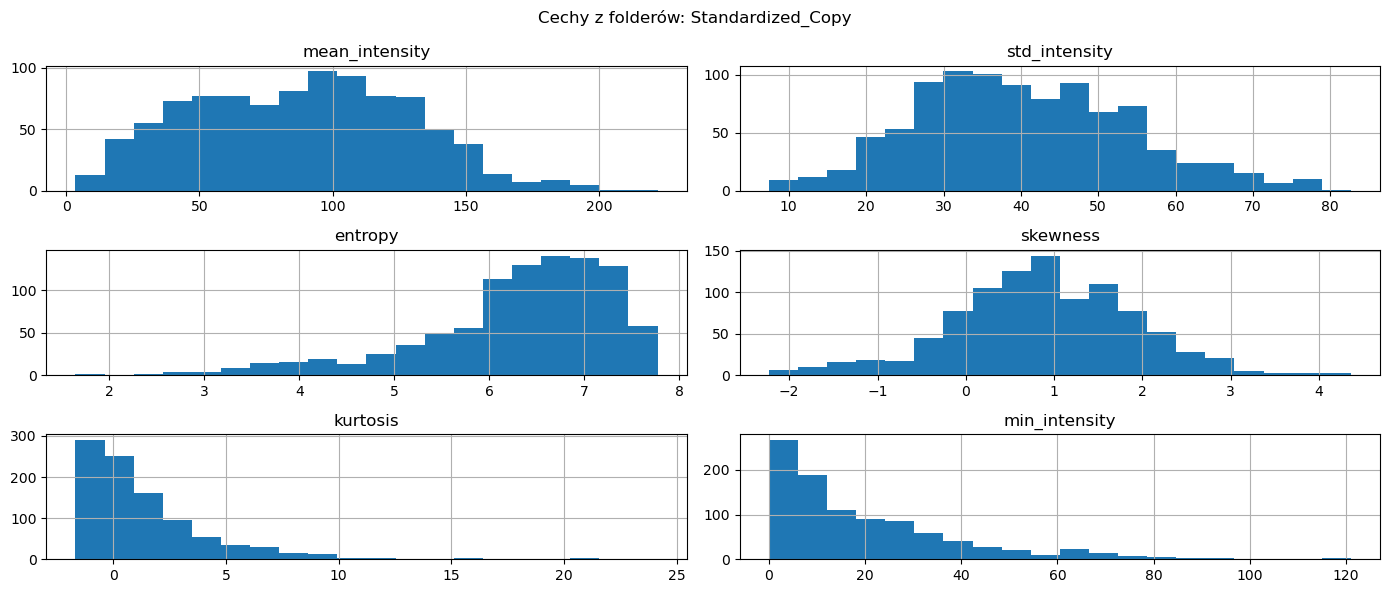

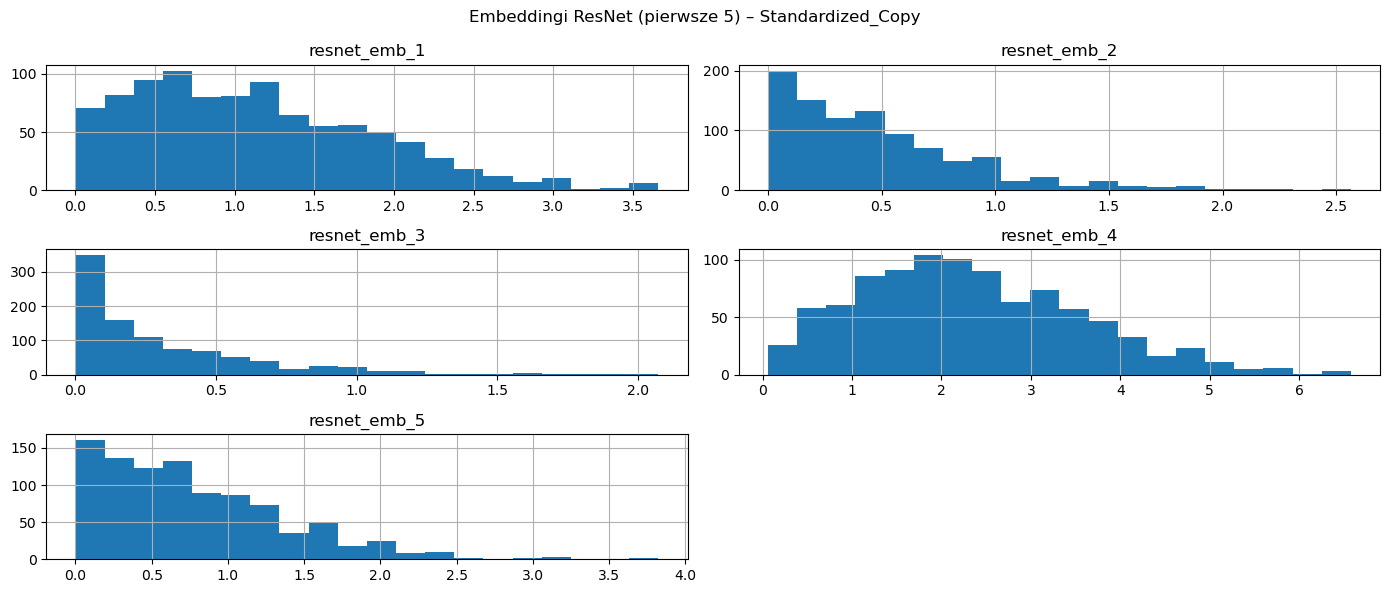

Przetwarzam folder: DATA\Train_Test_Valid

📊 Statystyki cech (data_tables/features_from_Train_Test_Valid.csv):

       mean_intensity  std_intensity  min_intensity  max_intensity  \
count      961.000000     961.000000     961.000000     961.000000   
mean        86.381546      45.013655      13.285120     233.064516   
std         42.017497      14.233452      19.361686      29.258332   
min          6.759825       9.674952       0.000000      69.000000   
25%         51.181382      34.245778       0.000000     221.000000   
50%         83.545769      44.417839       4.000000     246.000000   
75%        117.240613      54.477694      19.000000     254.000000   
max        226.289062      85.534833     113.000000     255.000000   

         skewness    kurtosis     entropy  haralick_1   haralick_2  \
count  961.000000  961.000000  961.000000  961.000000   961.000000   
mean     0.866168    1.208677    6.435501    0.032393   197.472418   
std      1.010768    2.741300    0.999555    0.

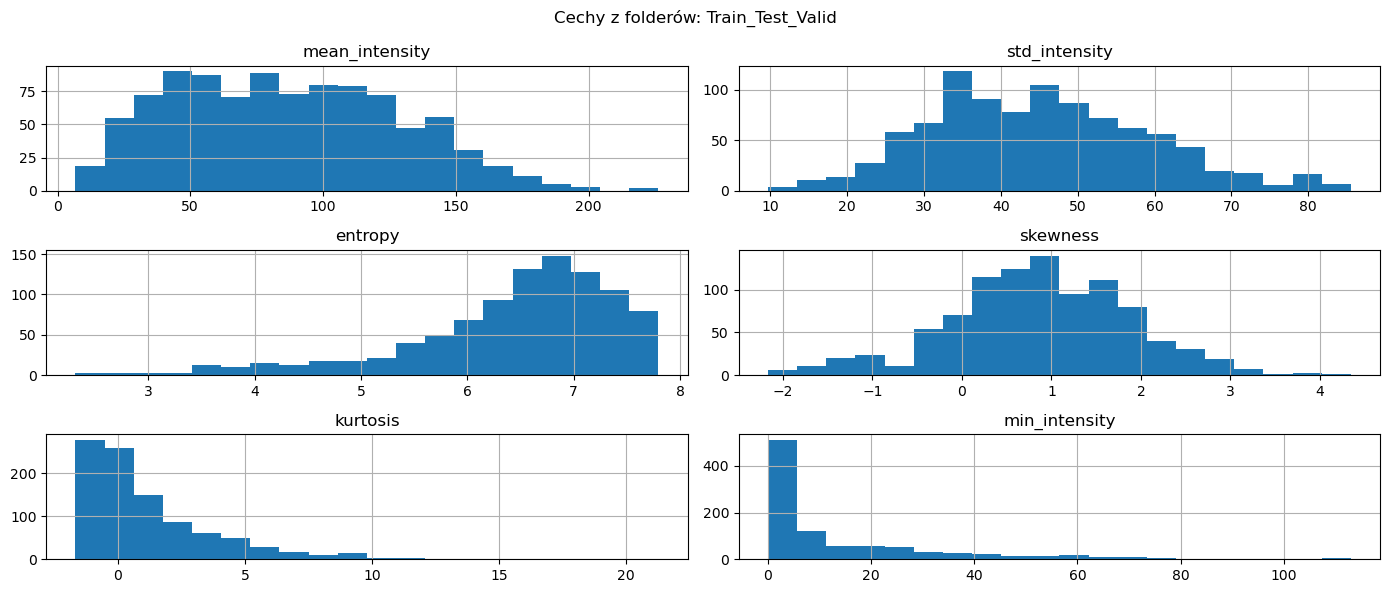

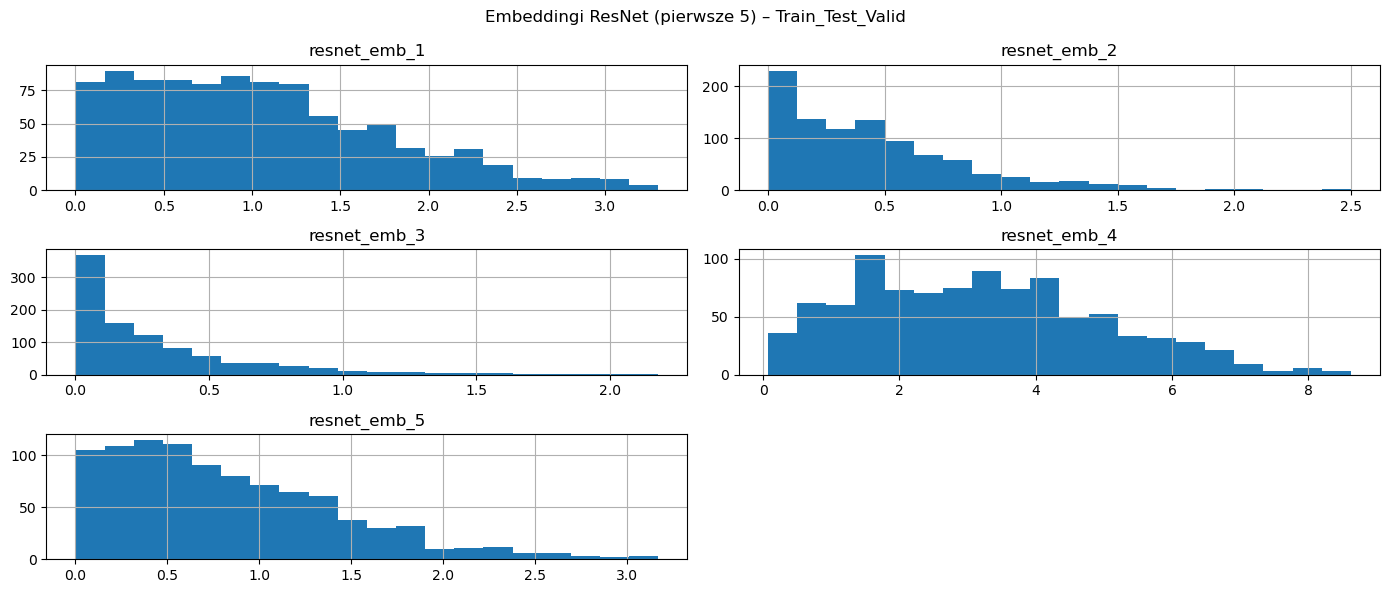

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
base_folder = "DATA"
subfolders = [os.path.join(base_folder, f) for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

for folder in subfolders:
    print(f"Przetwarzam folder: {folder}")
    extract_features_from_folders([folder])  # funkcja z poprzednich kroków
